In [1]:
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

import tabulate

import plotly.graph_objects as go
import plotly.express as px

## Get the necessary tables

In [2]:
# Print the current working directory
print("Current Working Directory:", Path.cwd())

# Results folder
results_folder = Path('./Results')

prob_data_dict = {}
risk_attr_dict = {}
risk_metrics_dict = {}

# Get all the folders in the results folder
sub_folders = [x for x in results_folder.iterdir() if x.is_dir()]

for folder in sub_folders:
    #  Get the two tables in the tables folder
    tables_folder = folder / 'Tables'
    try:
        # Read the article plot data
        prob_data_dict[folder.name] = pd.read_csv(tables_folder / 'article_plot_df.csv')
        # The risk attributes
        risk_attr_dict[folder.name] = pd.read_csv(tables_folder / 'risk_attr_incl_risk_transf_df.csv')
        # The risk metrics
        risk_metrics_dict[folder.name] = pd.read_csv(tables_folder / 'risk_metrics_df.csv')
        print(f"Processing {folder.name}")
    except FileNotFoundError:
        print(f"Tables not found in {folder}")

# 

Current Working Directory: /Users/vwattin/Documents/Programming/Climate/Finance/202312_TCFD_project
Processing TC_STORM_EC-Earth3P-HR_150as_global_nofraction
Processing TC_STORM_CMCC-CM2-VHR4_150as_global_nofraction
Tables not found in Results/Test
Processing TC_STORM_HadGEM3-GC31-HM_150as_global_nofraction
Processing TC_STORM_CNRM-CM6-1-HR_150as_global_nofraction
Tables not found in Results/Merged


In [3]:

# Print the first data frame in risk_metrics_dict in a tabular format
keys = list(risk_attr_dict.keys())
print(tabulate.tabulate(risk_attr_dict[keys[0]], headers='keys', tablefmt='psql'))

+----+--------------+---------------+---------------+----------------------+--------------+---------------+------------------------------+---------------------------------------+------------------------------------------------+
|    |   Unnamed: 0 | Time period   | Impact type   | Portfolio Strategy   | Company      |   Marginal ES | Risk Attribution             | legend_bar_Companies                  | legend_bar_Strategy                            |
|----+--------------+---------------+---------------+----------------------+--------------+---------------+------------------------------+---------------------------------------+------------------------------------------------|
|  0 |            0 | Historical    | Gross         | Globe<br>Pharma      | Globe Pharma |    0.207128   | Globe Pharma (Gross)         | Globe Pharma (Gross)                  | Globe Pharma (Gross)                           |
|  1 |            1 | Historical    | Gross         | Globe<br>Pharma      | NWP SEMICON

### Calculate the average 

In [4]:
def average_prob_data(prob_data_dict):
    # Extract all DataFrames from prob_data_dict into a list
    dfs = [df for df in prob_data_dict.values()]
    
    # Ensure all numeric columns are of a numeric type for each DataFrame
    dfs = [df.apply(pd.to_numeric, errors='ignore') for df in dfs]
    
    # Concatenate all DataFrames vertically
    concatenated_df = pd.concat(dfs)
    
    # Group the concatenated DataFrame by "Company combinations"
    grouped = concatenated_df.groupby('Company combinations')
    
    # Calculate the mean of the non-string (numeric) columns for each group
    average_df = grouped.mean().reset_index()
    
    return average_df

def average_risk_metrics(risk_metrics_dict):
    # Extract all DataFrames from risk_metrics_dict into a list
    dfs = [df for df in risk_metrics_dict.values()]
    
    # Ensure all numeric columns are of a numeric type for each DataFrame
    dfs = [df.apply(pd.to_numeric, errors='ignore') for df in dfs]
    
    # Concatenate all DataFrames vertically
    concatenated_df = pd.concat(dfs)
    
    # Drop the 'Unnamed: 0' column as it's likely an index column from CSV
    concatenated_df = concatenated_df.drop(columns=['Unnamed: 0'], errors='ignore')
    
    # Group the concatenated DataFrame by all non-numeric columns
    non_numeric_columns = concatenated_df.select_dtypes(exclude=['number']).columns.tolist()
    grouped = concatenated_df.groupby(non_numeric_columns)
    
    # Calculate the mean of the numeric columns for each group
    average_df = grouped.mean().reset_index()
    
    return average_df

def average_risk_attributes(risk_attr_dict):
    # Initialize an empty DataFrame to hold all data
    combined_df = pd.DataFrame()

    for key, df in risk_attr_dict.items():
        # Drop the 'Unnamed: 0' column as it's likely an index column from CSV
        df = df.drop(columns=['Unnamed: 0'], errors='ignore')
        
        # Ensure 'Marginal ES' is of numeric type
        df['Marginal ES'] = pd.to_numeric(df['Marginal ES'], errors='coerce')
        
        # Add a column to preserve the original order
        df['Original Order'] = range(len(df))
        
        # Append to the combined DataFrame
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    # Group the combined DataFrame by non-numeric columns
    group_cols = ['Time period', 'Impact type', 'Portfolio Strategy', 'Company', 
                  'Risk Attribution', 'legend_bar_Companies', 'legend_bar_Strategy']
    numeric_cols = ['Marginal ES']
    
    # Perform the grouping and calculate the mean
    grouped = combined_df.groupby(group_cols, sort=False).mean(numeric_only=True).reset_index()
    
    # Merge the results with the non-numeric columns
    final_columns = group_cols + numeric_cols
    
    # Restore the original order based on the 'Original Order' column
    average_df = grouped.sort_values(by='Original Order')[final_columns]
    
    return average_df


## Old probailistic plot style

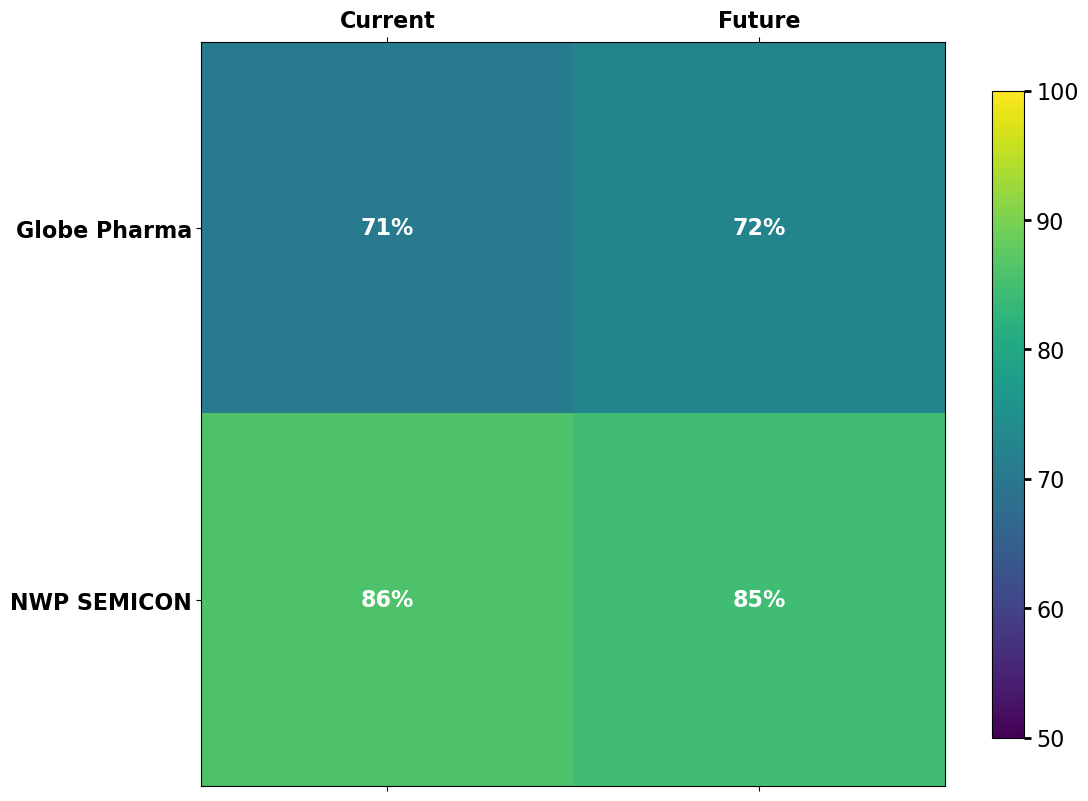

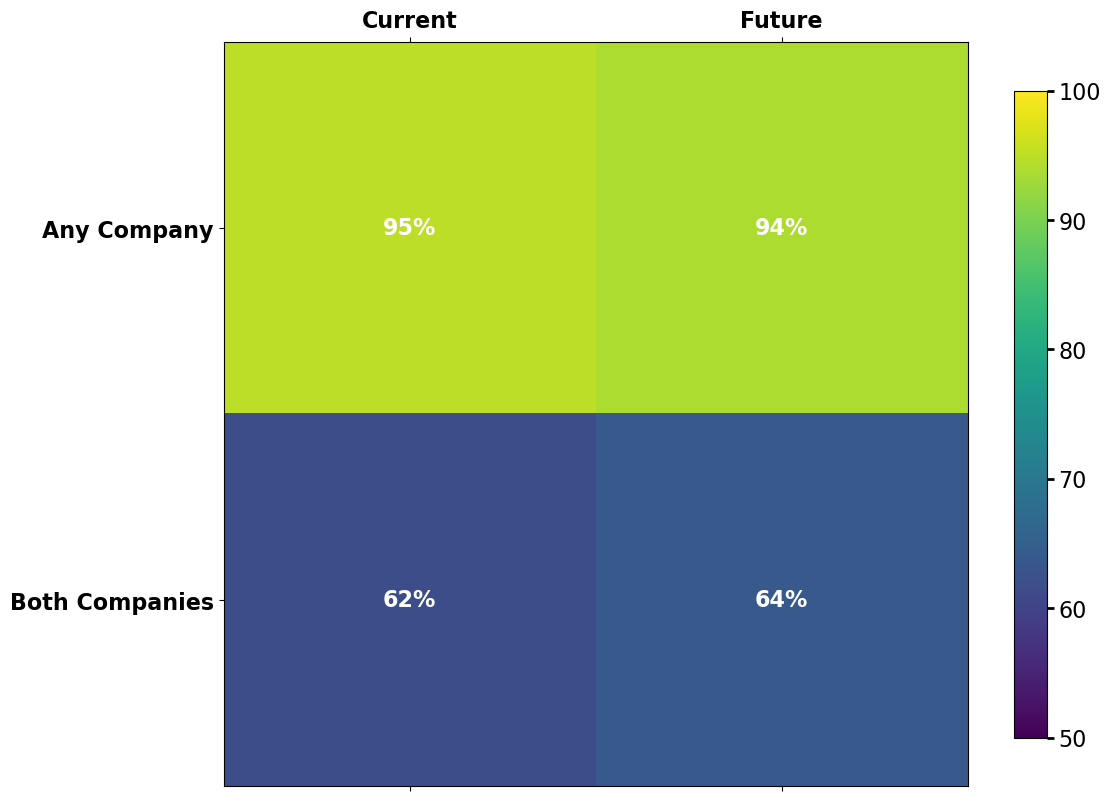

In [5]:
# Average the probability data
article_plot_df = average_prob_data(prob_data_dict)
# Set index as first column
article_plot_df.set_index(article_plot_df.columns[0], inplace=True)

# Color bar parameters
vmin = 50
vmax = 100
kwargs = {'aspect': 20, 'shrink': 0.7} #


# Set the colorbar parameters
colorbar_params = {'aspect': 20, 'shrink': 1}

# Set the font size for the plot
font_size = 16
tilt_degrees = 0

# Filter out the companies article_plot_df
only_companies_plot_df = article_plot_df[article_plot_df.index.isin(['Globe Pharma', 'NWP SEMICON'])]
# # Create the fifth figure
fig5, ax5 = plt.subplots(figsize=(12, 12))
cax5 = ax5.matshow(only_companies_plot_df, cmap='viridis', vmin=vmin, vmax=vmax)
colorbar = fig5.colorbar(cax5, ax=ax5, **kwargs)  # Adjust the colorbar parameters
colorbar.ax.tick_params(labelsize=font_size, width=2, length=5)  # Set the colorbar label size and style
ax5.set_xticks(range(len(only_companies_plot_df.columns)))
ax5.set_xticklabels(only_companies_plot_df.columns, fontsize=font_size, fontweight='bold')
ax5.set_yticks(range(len(only_companies_plot_df.index)))
ax5.set_yticklabels(only_companies_plot_df.index, fontsize=font_size, fontweight='bold', rotation=tilt_degrees)

# Remove grid lines
ax5.grid(False)

# Add the values to the plot as percentages
for i in range(len(only_companies_plot_df.index)):
    for j in range(len(only_companies_plot_df.columns)):
        ax5.text(j, i, f"{only_companies_plot_df.iloc[i, j]:.0f}%", ha='center', va='center', color='white', fontsize=font_size, fontweight='bold')
# Set x-label and y-label descriptions
# Print the title
# Save the fifth figure in high resolution as ProabilityOfImpact_OnlyCompanies
merged_folder = results_folder / 'Merged'
merged_folder.mkdir(exist_ok=True)
file = merged_folder / 'ProabilityOfImpact_OnlyCompanies.png'
fig5.savefig(file, dpi=300, bbox_inches='tight')
             


# Filter out non-companies
non_companies_plot_df = article_plot_df[~article_plot_df.index.isin(['Globe Pharma', 'NWP SEMICON'])]
# Create the sixth figure
fig6, ax6 = plt.subplots(figsize=(12, 12))
cax6 = ax6.matshow(non_companies_plot_df, cmap='viridis', vmin=vmin, vmax=vmax)
colorbar = fig6.colorbar(cax6, ax=ax6, **kwargs)  # Adjust the colorbar parameters
colorbar.ax.tick_params(labelsize=font_size, width=2, length=5)  # Set the colorbar label size and style
ax6.set_xticks(range(len(non_companies_plot_df.columns)))
ax6.set_xticklabels(non_companies_plot_df.columns, fontsize=font_size, fontweight='bold')
ax6.set_yticks(range(len(non_companies_plot_df.index)))
ax6.set_yticklabels(non_companies_plot_df.index, fontsize=font_size, fontweight='bold', rotation=tilt_degrees)

# Remove grid lines
ax6.grid(False)

# Add the values to the plot as percentages
for i in range(len(non_companies_plot_df.index)):
    for j in range(len(non_companies_plot_df.columns)):
        ax6.text(j, i, f"{non_companies_plot_df.iloc[i, j]:.0f}%", ha='center', va='center', color='white', fontsize=font_size, fontweight='bold')

# Save the sixth figure in high resolution
file = merged_folder / 'ProabilityOfImpact_OnlyPortfolio.png'
fig6.savefig(file, dpi=300, bbox_inches='tight')


## New probailistic plot style

In [6]:
import pandas as pd
import plotly.graph_objs as go

# Create the DataFrame
data = {
    'Current': [95.00, 61.50, 70.50, 85.75],
    'Future': [93.50, 64.00, 72.75, 85.00]
}
index = ['Any Company', 'Both Companies', 'Globe Pharma', 'NWP SEMICON']
df = pd.DataFrame(data, index=index)
df.index.name = 'Company combinations'

# Reset index to get 'Company combinations' as a column
df = df.reset_index()

# Reshape the DataFrame to long format
df_long = pd.melt(df, id_vars='Company combinations', var_name='Time period', value_name='Value')

# Define the color mapping with the specified order
ordered_companies = ['Globe Pharma', 'NWP SEMICON', 'Any Company', 'Both Companies']
company_colors = ['#ffca3a', '#06d6a0', '#ef476f', '#3a86ff']  # Turquoise, Yellow, Red, Blue

color_mapping_hex = {company: color for company, color in zip(ordered_companies, company_colors)}

# Create the figure
fig = go.Figure()

# Font properties
font_color = '#00008B'
font_family = 'Courier New' # bold
font_size = 38
max_value = df_long['Value'].max() + 10  # Adjust based on data

font_dict = dict(size=font_size, family=font_family, color=font_color)

# Update layout
fig.update_layout(
    template="plotly_white",
    #xaxis_title='Time period',
    yaxis_title='Annual Probability of Loss (%)',
    barmode="group",
    bargap=0.05,  # Reduce the gap between bars
    xaxis_title_font=dict(size=font_size, family=font_family, color=font_color),
    yaxis_title_font=dict(size=font_size, family=font_family, color=font_color),
    xaxis_tickfont=dict(size=font_size, family=font_family, color=font_color),
    yaxis_tickfont=dict(size=font_size, family=font_family, color=font_color),
    legend_font=dict(size=font_size, family=font_family, color=font_color),
    yaxis=dict(range=[0, max_value]), 
    height=1000*1.1,
    width=1800*1.1,
    legend=dict(
        #title=dict(text='Company combinations', font=dict(size=font_size, family=font_family, color=font_color)),
        orientation="h",
        yanchor="bottom",
        y=1.15,
        xanchor="center",
        x=0.5,
        bgcolor='rgba(255, 255, 255, 0.7)',
        bordercolor='black',
        borderwidth=2
    ),
)

# Add bars for each company combination in the specified order
for company in ordered_companies:
    plot_df = df_long[df_long['Company combinations'] == company]
    fig.add_trace(
        go.Bar(
            x=plot_df['Time period'], 
            y=plot_df['Value'], 
            name=company, 
            marker_color=color_mapping_hex[company], 
            textfont=dict(size=font_size, family=font_family, color=font_color),
            text=plot_df['Value'].round(2),  # Add the probability values on top of each bar
            textposition='outside'
        ),
    )

fig.show()

# Save the sixth figure in high resolution
file = merged_folder / 'ProabilityOfImpact.png'
fig.write_image(file,  scale=4)

In [61]:
import pandas as pd
import plotly.graph_objs as go

# Create the DataFrame
data = {
    'Current': [95.00, 61.50, 70.50, 85.75],
    'Future': [93.50, 64.00, 72.75, 85.00]
}
index = ['Any Company', 'Both Companies', 'Globe Pharma', 'NWP SEMICON']
df = pd.DataFrame(data, index=index)
df.index.name = 'Company combinations'

# Reset index to get 'Company combinations' as a column
df = df.reset_index()

# Define the color mapping with the specified order
ordered_companies = ['Globe Pharma', 'NWP SEMICON', 'Any Company', 'Both Companies']
company_colors = ['#ffca3a', '#06d6a0', '#ef476f', '#3a86ff']  # Turquoise, Yellow, Red, Blue

color_mapping_hex = {company: color for company, color in zip(ordered_companies, company_colors)}

# Create the figure
fig = go.Figure()

# Font properties
font_color = '#00008B'
font_family = 'Courier New' # bold
font_size = 38
max_value = df[['Current', 'Future']].max().max() + 10  # Adjust based on data

font_dict = dict(size=font_size, family=font_family, color=font_color)

# Add bars for each company combination in the specified order
for idx, (company, color) in enumerate(zip(ordered_companies, company_colors)):
    # Add "Current" bars (plain)
    fig.add_trace(
        go.Bar(
            x=[company], 
            y=[df.loc[df['Company combinations'] == company, 'Current'].values[0]], 
            name='Current' if idx == 0 else None,  # Show legend only for the first instance
            marker_color=color, 
            text=[df.loc[df['Company combinations'] == company, 'Current'].values[0]],
            textfont=dict(size=font_size, family=font_family, color=font_color),
            textposition='outside',
            legendgroup='Current',
            showlegend=idx == 0,
            offsetgroup='current'
        ),
    )
    
    # Add "Future" bars (striped)
    fig.add_trace(
        go.Bar(
            x=[company], 
            y=[df.loc[df['Company combinations'] == company, 'Future'].values[0]], 
            name='Future' if idx == 0 else None,  # Show legend only for the first instance
            marker_color=color, 
            marker_pattern_shape='/',
            text=[df.loc[df['Company combinations'] == company, 'Future'].values[0]],
            textfont=dict(size=font_size, family=font_family, color=font_color),
            textposition='outside',
            legendgroup='Future',
            showlegend=idx == 0,
            offsetgroup='future'
        ),
    )

fig.update_layout(
    template="plotly_white",
    xaxis_title='Company combinations',
    yaxis_title='Annual Probability of loss (%)',
    barmode="group",
    bargap=0.15,  # Reduce the gap between bars
    xaxis_title_font=dict(size=font_size, family=font_family, color=font_color),
    yaxis_title_font=dict(size=font_size, family=font_family, color=font_color),
    xaxis_tickfont=dict(size=font_size, family=font_family, color=font_color),
    yaxis_tickfont=dict(size=font_size, family=font_family, color=font_color),
    legend_font=dict(size=font_size, family=font_family, color=font_color),
    yaxis=dict(range=[0, max_value]), 
    height=1000*1.1,
    width=1800*1.1,
    legend=dict(
        #title=dict(text='Time period', font=dict(size=font_size, family=font_family, color=font_color)),
        orientation="h",
        yanchor="bottom",
        y=1.15,
        xanchor="center",
        x=0.5,
        bgcolor='rgba(255, 255, 255, 0.7)',
        bordercolor='black',
        borderwidth=2
    ),
    xaxis=dict(
        #title='Company combinations',
        tickvals=ordered_companies,
        ticktext=ordered_companies
    )
)

fig.show()

# Save the figure as a PNG file
file = 'ProabilityOfImpact.png'
fig.write_image(file, scale=4)


### Plot the risk attribution

In [8]:
risk_attr_incl_risk_transf_df = risk_attr_dict[keys[0]]

print('The risk attribution including the risk transfer')
print(tabulate.tabulate(risk_attr_incl_risk_transf_df, headers='keys', tablefmt='pipe'), '\n')

The risk attribution including the risk transfer
|    |   Unnamed: 0 | Time period   | Impact type   | Portfolio Strategy   | Company      |   Marginal ES | Risk Attribution             | legend_bar_Companies                  | legend_bar_Strategy                            |
|---:|-------------:|:--------------|:--------------|:---------------------|:-------------|--------------:|:-----------------------------|:--------------------------------------|:-----------------------------------------------|
|  0 |            0 | Historical    | Gross         | Globe<br>Pharma      | Globe Pharma |    0.207128   | Globe Pharma (Gross)         | Globe Pharma (Gross)                  | Globe Pharma (Gross)                           |
|  1 |            1 | Historical    | Gross         | Globe<br>Pharma      | NWP SEMICON  |    0          | NWP SEMICON (Gross)          | NWP SEMICON (Gross)                   | NWP SEMICON (Gross)                            |
|  2 |            2 | Historical    | G

### Utility function for plotting

In [9]:
# Filter the data based on a dictionary of filters

def filter_dataframe(df, filters, columns_to_remove):
    df_copy = df.copy()  # make a copy of the DataFrame
    for col, values in filters.items():
        df_copy = df_copy[df_copy[col].isin(values)]
    df_copy = df_copy.drop(columns=columns_to_remove)
    return df_copy


### Define the colors

In [10]:
import seaborn as sns
import re
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import matplotlib

# Color inspiration: https://coolors.co/palettes/trending

# Colours and labels for legend
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#ef476f', '#3a86ff', '#06d6a0'])
label = ('Globe Pharma', 'NWP SEMICON')
company_colors = ['#06d6a0', '#ffca3a']  # Turquoise and Yellow

# Specific color for NWP SEMICON
green_turquoise_hex = '#40e0d0'  # More greenish turquoise color

# Create color mapping for companies
unique_companies = risk_attr_incl_risk_transf_df['Company'].unique()
company_colors = dict(zip(unique_companies, sns.color_palette("hls", len(unique_companies))))

# Set NWP SEMICON to a specific color
company_colors['NWP SEMICON'] = '#06d6a0'  # Use the first color for NWP SEMICON
company_colors['Globe Pharma'] = '#ffca3a'  # Use the second color for Globe Pharma


# Create the color mapping dictionary
color_mapping = {}

# Assign distinct color to (netto) and light version of the color to (gross) for each company
for company in unique_companies:
    if company in company_colors:
        color_mapping[company] = company_colors[company]
        color_mapping[company + ' (Net)'] = company_colors[company]
        color_mapping[company + ' (Risk Transfer)'] = sns.light_palette(company_colors[company])[2]  # Use a lighter shade for gross
        # For the legend bars
        color_mapping[company + ' - ES'] = company_colors[company]
        color_mapping[company + ' - ES Insurance Reduction'] = sns.light_palette(company_colors[company])[2]
        color_mapping[company + ' - Marginal ES'] = company_colors[company]
        color_mapping[company + ' - MES Insurance Reduction'] = sns.light_palette(company_colors[company])[2]

color_mapping

# Convert RGB colors to hexadecimal format
color_mapping_hex = {k: mcolors.rgb2hex(v) for k, v in color_mapping.items()}



### Plot - Risk per company

In [11]:
portfolio_strategies = ['Globe Pharma', 'NWP SEMICON', 'Equal', 'Optimal']

In [12]:
risk_attr_incl_risk_transf_df = average_risk_attributes(risk_attr_dict)
#risk_attr_incl_risk_transf_df = risk_attr_dict[keys[0]]

# Reorder the data frame by Portfolio Strategy column based on the values as ['Globe<br>Pharma', 'NWP<br>SEMICON', 'Equal', 'Optimal']

#risk_attr_incl_risk_transf_df = risk_attr_dict[keys[0]]
print('The risk attribution including the risk transfer')
print(tabulate.tabulate(risk_attr_incl_risk_transf_df, headers='keys', tablefmt='pipe'), '\n')


# Filter the data based on a dictionary of filters
risk_metrics_df = average_risk_metrics(risk_metrics_dict)


The risk attribution including the risk transfer
|    | Time period   | Impact type   | Portfolio Strategy   | Company      | Risk Attribution             | legend_bar_Companies                  | legend_bar_Strategy                            |   Marginal ES |
|---:|:--------------|:--------------|:---------------------|:-------------|:-----------------------------|:--------------------------------------|:-----------------------------------------------|--------------:|
|  0 | Historical    | Gross         | Globe<br>Pharma      | Globe Pharma | Globe Pharma (Gross)         | Globe Pharma (Gross)                  | Globe Pharma (Gross)                           |    0.207425   |
|  1 | Historical    | Gross         | Globe<br>Pharma      | NWP SEMICON  | NWP SEMICON (Gross)          | NWP SEMICON (Gross)                   | NWP SEMICON (Gross)                            |    0          |
|  2 | Historical    | Gross         | NWP<br>SEMICON       | Globe Pharma | Globe Pharma (Gross)  

In [13]:
# For a given Time period, Impact type, Portfolio Strategy get me the sum of the Marginal ES of the data frame risk_attr_incl_risk_transf_df

# Define the filters
time_period = 'Historical'
impact_type = 'Gross'
portfolio_strategy = 'Globe<br>Pharma'

# Filter the DataFrame based on the given criteria
filtered_df = risk_attr_incl_risk_transf_df[
    (risk_attr_incl_risk_transf_df['Time period'] == time_period) &
    (risk_attr_incl_risk_transf_df['Impact type'] == impact_type) &
    (risk_attr_incl_risk_transf_df['Portfolio Strategy'] == portfolio_strategy)
]

# Calculate the sum of Marginal ES
marginal_es_sum = filtered_df['Marginal ES'].sum()



                               



In [14]:
# Define the filters
filters = { 'Portfolio Strategy': [port_strat.replace(' ', '<br>') for port_strat in portfolio_strategies[0:2]], 
           'Impact type': ['Net', 'Risk Transfer'], 'Time period': ['Current','Future']}

# Define the columns to remove
columns_to_remove = []

# Decide if value at risk is plotted
plot_var = False

# Filter the data frame
filt_risk_attr_df = filter_dataframe(risk_attr_incl_risk_transf_df, filters, columns_to_remove)
df = filt_risk_attr_df

group_col = 'Time period'
sub_group_col = 'Portfolio Strategy'
legend_col = 'legend_bar_Companies'# 'Risk Attribution'
stack_col = 'Marginal ES'


xaxis_title = ''
yaxis_title = 'Replacement Costs (US$ billion)'

# Create a new figure
fig = go.Figure()

# Font color dark blue
font_color = '#00008B'
font_family = 'Courier New' # bold
font_size = 38
adjustment = 0.00
max_value = 0.50

font_dict = dict(size=font_size, family=font_family, color=font_color)

fig.update_layout(
    template="plotly_white",
    xaxis_title=xaxis_title,
    yaxis_title=yaxis_title,
    barmode="stack",
    bargap=0.1,
    xaxis_title_font=dict(size=font_size, family=font_family, color=font_color),
    yaxis_title_font=dict(size=font_size, family=font_family, color=font_color),
    xaxis_tickfont=dict(size=font_size, family=font_family, color=font_color),
    yaxis_tickfont=dict(size=font_size, family=font_family, color=font_color),
    legend_font=dict(size=font_size, family=font_family, color=font_color),
    yaxis=dict(range=[0, max_value]), 
    height=1000*1.1,
    width=1800*1.1,
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="center",
        x=0.5
    ),
    # Reverse the legend order
    legend_traceorder="reversed",
)



# Begin with the Net Risk
# Get the legend values in alphabetical order
legend_values = df[legend_col].unique()
# Reverse the order of the legend values
legend_values = legend_values[::-1]
# Only include net 
legend_values_Net = [leg for leg in legend_values if 'Net' in leg or 'Insurance' not in leg]



# Get the colors for the legend values
colors = [color_mapping_hex[legend_value] for legend_value in legend_values_Net]


# For each unique value in the legend column and its corresponding color
for legend_value, color in zip(legend_values_Net, colors):
    print(legend_value)
    # Filter the DataFrame to only include rows with the current legend value
    plot_df = df[df[legend_col] == legend_value]

    # Add a bar to the figure for the current legend value
    fig.add_trace(
        go.Bar(
            x=[plot_df[group_col], plot_df[sub_group_col]], 
            y=plot_df[stack_col], 
            name=legend_value, 
            marker_color=color, 
            textfont=dict(size=font_size, family=font_family, color=font_color),
        ),
    )

    
# Plot the VaR Net
if plot_var:
    for i, time in enumerate(df['Time period'].unique()):
        for j, port_strat in enumerate(df['Portfolio Strategy'].unique()):
            # Get the Gross VaR from risk metrics df
            net_var = risk_metrics_df[(risk_metrics_df['Time period'] == time) & (risk_metrics_df['Portfolio Strategy'] == port_strat) & (risk_metrics_df['Impact type'] == 'Net')]['VaR'].values[0]

            # Convert time and company to pandas Series with a single value
            time_series = pd.Series([time])
            company_series = pd.Series([port_strat])

            # Add of the VaR Gross
            fig.add_trace(
                go.Scatter(
                    x= [time_series, company_series],
                    y= [net_var], 
                    marker_color= 'black',
                    marker_symbol= 'x',
                    name= '1% Value-At-Risk (Net)', 
                    mode='markers',
                    showlegend= i == 0 and j ==0,
                    marker_size= 20
                ),
            )



# Begin with the Gross Risk
# Get the legend values in alphabetical order
legend_values_RT = [leg for leg in legend_values if 'Risk Transfer' in leg or 'Insurance' in leg]


# Get the colors for the legend values
colors = [color_mapping_hex[legend_value] for legend_value in legend_values_RT]





# For each unique value in the legend column and its corresponding color
for legend_value, color in zip(legend_values_RT, colors):
    # Filter the DataFrame to only include rows with the current legend value
    plot_df = df[df[legend_col] == legend_value]

    # Add a bar to the figure for the current legend value
    fig.add_trace(
        go.Bar(
            x=[plot_df[group_col], plot_df[sub_group_col]], 
            y=plot_df[stack_col], 
            name=legend_value, 
            marker_color=color, 
            textfont=dict(size=font_size, family=font_family, color=font_color),
        ),
    )


    
# # Plot the VaR Gross
# if plot_var:
#     for i, time in enumerate(df['Time period'].unique()):
#         for j, port_strat in enumerate(df['Portfolio Strategy'].unique()):
#             # Get the Gross VaR from risk metrics df
#             gross_var = risk_metrics_df[(risk_metrics_df['Time period'] == time) & (risk_metrics_df['Portfolio Strategy'] == port_strat) & (risk_metrics_df['Impact type'] == 'Gross')]['VaR'].values[0]

#             # Convert time and company to pandas Series with a single value
#             time_series = pd.Series([time])
#             company_series = pd.Series([port_strat])

#             # Add of the VaR Gross
#             fig.add_trace(
#                 go.Scatter(
#                     x= [time_series, company_series],
#                     y= [gross_var], 
#                     marker_color= 'black',
#                     name= '1% Value-At-Risk (Gross)', 
#                     mode='markers',
#                     showlegend= i == 0 and j ==0,
#                     marker_size= 20
#                 ),
#             )


# Always add the ES Gross
for time in df['Time period'].unique():
    for port_strat in df['Portfolio Strategy'].unique():
        # Get the Gross ES from risk metrics df
        #gross_es = risk_metrics_df[(risk_metrics_df['Time period'] == time) & (risk_metrics_df['Portfolio Strategy'] == port_strat) & (risk_metrics_df['Impact type'] == 'Gross')]['ES'].values[0]
        # Filter the DataFrame based on the given criteria
        filtered_df = risk_attr_incl_risk_transf_df[
            (risk_attr_incl_risk_transf_df['Time period'] == time) &
            (risk_attr_incl_risk_transf_df['Impact type'] == 'Gross') &
            (risk_attr_incl_risk_transf_df['Portfolio Strategy'] == port_strat)
        ]

        # Calculate the sum of Marginal ES
        gross_es = filtered_df['Marginal ES'].sum()

        # Convert time and company to pandas Series with a single value
        time_series = pd.Series([time])
        company_series = pd.Series([port_strat])

        # Add of the ES Gross as text on the top of the bar
        fig.add_trace(
            go.Scatter(
                x= [time_series, company_series],
                y= [gross_es + adjustment],
                name= 'ES Gross', 
                mode='text',
                text= [gross_es.round(2)],
                textposition='top center',
                textfont=dict(
                    color='black', 
                    size=font_size, 
                    family= font_family
                ),
                showlegend=False
            ),
        )




fig.show()

# Save the figure as a PNG file
file = merged_folder / 'Company Risks.png'
fig.write_image(file,  scale=4)


NWP SEMICON - ES
Globe Pharma - ES


In [57]:
# Define the filters
filters = { 'Portfolio Strategy': [port_strat.replace(' ', '<br>') for port_strat in portfolio_strategies[0:2]], 
           'Impact type': ['Net', 'Risk Transfer'], 'Time period': ['Current','Future']}

# Define the columns to remove
columns_to_remove = []

# Decide if value at risk is plotted
plot_var = False

# Filter the data frame
filt_risk_attr_df = filter_dataframe(risk_attr_incl_risk_transf_df, filters, columns_to_remove)
df = filt_risk_attr_df

group_col = 'Portfolio Strategy' 
sub_group_col = 'Time period'
legend_col = 'legend_bar_Companies'# 'Risk Attribution'
stack_col = 'Marginal ES'


xaxis_title = ''
yaxis_title = 'Replacement Costs (US$ billion)'

# Create a new figure
fig = go.Figure()

# Adjust the gap between bars for "Current" and "Future"
bargap_value = 0.01  # Adjust this value to reduce the space between bar groups
bargroupgap_value = 0.02  # Adjust this value to reduce the space between individual bars within a group

# Font color dark blue
font_color = '#00008B'
font_family = 'Courier New' # bold
font_size = 38
adjustment = 0.00
max_value = 0.50

font_dict = dict(size=font_size, family=font_family, color=font_color)

fig.update_layout(
    template="plotly_white",
    xaxis_title=xaxis_title,
    yaxis_title=yaxis_title,
    barmode="stack",
    bargap=bargap_value,  # Set the gap between groups of bars
    bargroupgap=bargroupgap_value,  # Set the gap between bars within the same group
    xaxis_title_font=dict(size=font_size, family=font_family, color=font_color),
    yaxis_title_font=dict(size=font_size, family=font_family, color=font_color),
    xaxis_tickfont=dict(size=font_size, family=font_family, color=font_color),
    yaxis_tickfont=dict(size=font_size, family=font_family, color=font_color),
    legend_font=dict(size=font_size, family=font_family, color=font_color),
    yaxis=dict(range=[0, max_value]), 
    height=1000*1.1,
    width=1800*1.1,
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="center",
        x=0.5
    ),
    # Reverse the legend order
    legend_traceorder="reversed",
)



# Begin with the Net Risk
# Get the legend values in alphabetical order
legend_values = df[legend_col].unique()
# Reverse the order of the legend values
legend_values = legend_values[::-1]
# Only include net 
legend_values_Net = [leg for leg in legend_values if 'Net' in leg or 'Insurance' not in leg]



# Get the colors for the legend values
colors = [color_mapping_hex[legend_value] for legend_value in legend_values_Net]


# For each unique value in the legend column and its corresponding color (Net Risk)
for legend_value, color in zip(legend_values_Net, colors):
    # Filter the DataFrame to only include rows with the current legend value
    plot_df = df[df[legend_col] == legend_value]

    for time_period in plot_df[sub_group_col].unique():
        time_filtered_df = plot_df[plot_df[sub_group_col] == time_period]

        # Apply dashed line pattern to "Future" time period
        if time_period == "Future":
            pattern_shape = "/"  # diagonal lines
            show_legend = False  # Do not show in legend
        else:
            pattern_shape = ""
            show_legend = True  # Show in legend

        # Add a bar to the figure for the current legend value
        fig.add_trace(
            go.Bar(
                x=[time_filtered_df[group_col], time_filtered_df[sub_group_col]],
                y=time_filtered_df[stack_col],
                name=legend_value if show_legend else None,
                marker_color=color,
                textfont=dict(size=font_size, family=font_family, color=font_color),
                marker=dict(pattern_shape=pattern_shape),
                showlegend=show_legend,
            ),
        )


# Begin with the Gross Risk
# Get the legend values in alphabetical order
legend_values_RT = [leg for leg in legend_values if 'Risk Transfer' in leg or 'Insurance' in leg]


# Get the colors for the legend values
colors = [color_mapping_hex[legend_value] for legend_value in legend_values_RT]


# For Gross Risk (Risk Transfer)
for legend_value, color in zip(legend_values_RT, colors):
    # Filter the DataFrame to only include rows with the current legend value
    plot_df = df[df[legend_col] == legend_value]

    for time_period in plot_df[sub_group_col].unique():
        time_filtered_df = plot_df[plot_df[sub_group_col] == time_period]

        # Apply dashed line pattern to "Future" time period
        if time_period == "Future":
            pattern_shape = "/"  # diagonal lines
            show_legend = False  # Do not show in legend
        else:
            pattern_shape = ""
            show_legend = True  # Show in legend

        # Add a bar to the figure for the current legend value
        fig.add_trace(
            go.Bar(
                x=[time_filtered_df[group_col], time_filtered_df[sub_group_col]],
                y=time_filtered_df[stack_col],
                name=legend_value if show_legend else None,
                marker_color=color,
                textfont=dict(size=font_size, family=font_family, color=font_color),
                marker=dict(pattern_shape=pattern_shape),
                showlegend=show_legend,
            ),
        )

# Always add the ES Gross
for time in df['Time period'].unique():
    for port_strat in df['Portfolio Strategy'].unique():
        # Get the Gross ES from risk metrics df
        #gross_es = risk_metrics_df[(risk_metrics_df['Time period'] == time) & (risk_metrics_df['Portfolio Strategy'] == port_strat) & (risk_metrics_df['Impact type'] == 'Gross')]['ES'].values[0]
        # Filter the DataFrame based on the given criteria
        filtered_df = risk_attr_incl_risk_transf_df[
            (risk_attr_incl_risk_transf_df['Time period'] == time) &
            (risk_attr_incl_risk_transf_df['Impact type'] == 'Gross') &
            (risk_attr_incl_risk_transf_df['Portfolio Strategy'] == port_strat)
        ]

        # Calculate the sum of Marginal ES
        gross_es = filtered_df['Marginal ES'].sum()

        # Convert time and company to pandas Series with a single value
        time_series = pd.Series([time])
        company_series = pd.Series([port_strat])

        # Add of the ES Gross as text on the top of the bar
        fig.add_trace(
            go.Scatter(
                x= [company_series, time_series],
                y= [gross_es + adjustment],
                name= 'ES Gross', 
                mode='text',
                text= [gross_es.round(2)],
                textposition='top center',
                textfont=dict(
                    color='black', 
                    size=font_size, 
                    family= font_family
                ),
                showlegend=False
            ),
        )
        
fig.show()

# Save the figure as a PNG file
file = merged_folder / 'Company Risks.png'
fig.write_image(file,  scale=4)


### Plot - Risk attribution per company and strategy

In [52]:
# Define the filters
filters = { 'Portfolio Strategy': [port_strat.replace(' ', '<br>') for port_strat in portfolio_strategies[:]],
           'Time period': ['Current','Future'],
           'Impact type': ['Net', 'Risk Transfer']}
# Define the columns to remove
columns_to_remove = []

# Decide if value at risk is plotted
plot_var = False


# Filter the data frame
filt_risk_attr_df = filter_dataframe(risk_attr_incl_risk_transf_df, filters, columns_to_remove)
df = filt_risk_attr_df

group_col = 'Time period'
sub_group_col = 'Portfolio Strategy'
legend_col = 'legend_bar_Strategy' #'Risk Attribution'
stack_col = 'Marginal ES'


xaxis_title = ''
yaxis_title = 'Replacement Costs (US$ billion)'

# Create a new figure
fig = go.Figure()

# Font color dark blue
font_color = '#00008B'
font_family = 'Courier New' # bold
font_size = 40
adjustment = 0.00

font_dict = dict(size=font_size, family=font_family, color=font_color)

fig.update_layout(
    template="plotly_white",
    xaxis_title=xaxis_title,
    yaxis_title=yaxis_title,
    barmode="stack",
    bargap=0.2,
    xaxis_title_font=dict(size=font_size, family=font_family, color=font_color),
    yaxis_title_font=dict(size=font_size, family=font_family, color=font_color),
    xaxis_tickfont=dict(size=font_size, family=font_family, color=font_color),
    yaxis_tickfont=dict(size=font_size, family=font_family, color=font_color),
    legend_font=dict(size=font_size, family=font_family, color=font_color),
    height=1000*1.2,
    width=1800*1.2,
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="center",
        x=0.5
    ),
    # Reverse the legend order
    legend_traceorder="reversed",
)


# Begin with the Net Risk
# Get the legend values in alphabetical order
legend_values = df[legend_col].unique()
# Reverse the order of the legend values
legend_values = legend_values[::-1]
# Only include net 
legend_values_Net = [leg for leg in legend_values if 'Net' in leg or 'Insurance' not in leg]


# Get the colors for the legend values
colors = [color_mapping_hex[legend_value] for legend_value in legend_values_Net]




# For each unique value in the legend column and its corresponding color
for legend_value, color in zip(legend_values_Net, colors):
    # Filter the DataFrame to only include rows with the current legend value
    plot_df = df[df[legend_col] == legend_value]

    # Replace spaces in the x-axis labels with line breaks
    x_labels = [label.replace(' ', '<br>') for label in plot_df[sub_group_col]]

    # Add a bar to the figure for the current legend value
    fig.add_trace(
        go.Bar(
            x=[plot_df[group_col], x_labels], 
            y=plot_df[stack_col], 
            name=legend_value, 
            marker_color=color, 
            textfont=dict(size=font_size, family=font_family, color=font_color),
        ),
    )


# Plot the VaR Gross
if plot_var:
    for i, time in enumerate(df['Time period'].unique()):
        for j, port_strat in enumerate(df['Portfolio Strategy'].unique()):
            # Get the Net VaR from risk metrics df
            net_var = risk_metrics_df[(risk_metrics_df['Time period'] == time) & (risk_metrics_df['Portfolio Strategy'] == port_strat) & (risk_metrics_df['Impact type'] == 'Net')]['VaR'].values[0]
            net_es = risk_metrics_df[(risk_metrics_df['Time period'] == time) & (risk_metrics_df['Portfolio Strategy'] == port_strat) & (risk_metrics_df['Impact type'] == 'Net')]['ES'].values[0]

            # Convert time and company to pandas Series with a single value
            time_series = pd.Series([time])
            company_series = pd.Series([port_strat])

            # Add of the VaR Gross
            fig.add_trace(
                go.Scatter(
                    x= [time_series, company_series],
                    y= [net_var], 
                    marker_color= 'black',
                    marker_symbol= 'x',
                    name= '1% Value-At-Risk (Net)', 
                    mode='markers',
                    showlegend= i == 0 and j ==0,
                    marker_size= 20
                ),
            )

# Always add the ES Net
for i, time in enumerate(df['Time period'].unique()):
    for j, port_strat in enumerate(df['Portfolio Strategy'].unique()):
        # Get the Net VaR from risk metrics df
        #net_var = risk_metrics_df[(risk_metrics_df['Time period'] == time) & (risk_metrics_df['Portfolio Strategy'] == port_strat) & (risk_metrics_df['Impact type'] == 'Net')]['VaR'].values[0]
        #net_es = risk_metrics_df[(risk_metrics_df['Time period'] == time) & (risk_metrics_df['Portfolio Strategy'] == port_strat) & (risk_metrics_df['Impact type'] == 'Net')]['ES'].values[0]

        filtered_df = risk_attr_incl_risk_transf_df[
                (risk_attr_incl_risk_transf_df['Time period'] == time) &
                (risk_attr_incl_risk_transf_df['Impact type'] == 'Net') &
                (risk_attr_incl_risk_transf_df['Portfolio Strategy'] == port_strat)
            ]

        # Calculate the sum of Marginal ES
        net_es = filtered_df['Marginal ES'].sum()
    
        # Convert time and company to pandas Series with a single value
        time_series = pd.Series([time])
        company_series = pd.Series([port_strat])
        # Add of the ES Net as text on the top of the bar
        fig.add_trace(
            go.Scatter(
                x= [time_series, company_series],
                y= [net_es + adjustment],
                name= 'ES Net', 
                mode='text',
                text= [net_es.round(2)],
                textposition='top center',
                    textfont=dict(
                    color='black', 
                    size=font_size, 
                    family= font_family
                ),
                showlegend=False
            ),
    )



# Always add the ES Net

fig.show()
file = merged_folder / 'Portfolio Strategy.png'
fig.write_image(file,  scale=4)


In [56]:
# Define the filters
filters = { 'Portfolio Strategy': [port_strat.replace(' ', '<br>') for port_strat in portfolio_strategies[:]],
           'Time period': ['Current','Future'],
           'Impact type': ['Net', 'Risk Transfer']}
# Define the columns to remove
columns_to_remove = []

# Decide if value at risk is plotted
plot_var = False


# Filter the data frame
filt_risk_attr_df = filter_dataframe(risk_attr_incl_risk_transf_df, filters, columns_to_remove)
df = filt_risk_attr_df

group_col = 'Portfolio Strategy' 
sub_group_col = 'Time period'
legend_col = 'legend_bar_Companies'# 'Risk Attribution'
stack_col = 'Marginal ES'


xaxis_title = ''
yaxis_title = 'Replacement Costs (US$ billion)'

# Create a new figure
fig = go.Figure()

# Adjust the gap between bars for "Current" and "Future"
bargap_value = 0.01  # Adjust this value to reduce the space between bar groups
bargroupgap_value = 0.02  # Adjust this value to reduce the space between individual bars within a group

# Font color dark blue
font_color = '#00008B'
font_family = 'Courier New' # bold
font_size = 38
adjustment = 0.00
max_value = 0.50

font_dict = dict(size=font_size, family=font_family, color=font_color)

fig.update_layout(
    template="plotly_white",
    xaxis_title=xaxis_title,
    yaxis_title=yaxis_title,
    barmode="stack",
    bargap=bargap_value,  # Set the gap between groups of bars
    bargroupgap=bargroupgap_value,  # Set the gap between bars within the same group
    xaxis_title_font=dict(size=font_size, family=font_family, color=font_color),
    yaxis_title_font=dict(size=font_size, family=font_family, color=font_color),
    xaxis_tickfont=dict(size=font_size, family=font_family, color=font_color),
    yaxis_tickfont=dict(size=font_size, family=font_family, color=font_color),
    legend_font=dict(size=font_size, family=font_family, color=font_color),
    yaxis=dict(range=[0, max_value]), 
    height=1000*1.1,
    width=1800*1.1,
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="center",
        x=0.5
    ),
    # Reverse the legend order
    legend_traceorder="reversed",
)



# Begin with the Net Risk
# Get the legend values in alphabetical order
legend_values = df[legend_col].unique()
# Reverse the order of the legend values
legend_values = legend_values[::-1]
# Only include net 
legend_values_Net = [leg for leg in legend_values if 'Net' in leg or 'Insurance' not in leg]



# Get the colors for the legend values
colors = [color_mapping_hex[legend_value] for legend_value in legend_values_Net]


# For each unique value in the legend column and its corresponding color (Net Risk)
for legend_value, color in zip(legend_values_Net, colors):
    # Filter the DataFrame to only include rows with the current legend value
    plot_df = df[df[legend_col] == legend_value]

    for time_period in plot_df[sub_group_col].unique():
        time_filtered_df = plot_df[plot_df[sub_group_col] == time_period]

        # Apply dashed line pattern to "Future" time period
        if time_period == "Future":
            pattern_shape = "/"  # diagonal lines
            show_legend = False  # Do not show in legend
        else:
            pattern_shape = ""
            show_legend = True  # Show in legend

        # Add a bar to the figure for the current legend value
        fig.add_trace(
            go.Bar(
                x=[time_filtered_df[group_col], time_filtered_df[sub_group_col]],
                y=time_filtered_df[stack_col],
                name=legend_value if show_legend else None,
                marker_color=color,
                textfont=dict(size=font_size, family=font_family, color=font_color),
                marker=dict(pattern_shape=pattern_shape),
                showlegend=show_legend,
            ),
        )


# Always add the ES Net
for i, time in enumerate(df['Time period'].unique()):
    for j, port_strat in enumerate(df['Portfolio Strategy'].unique()):
        # Get the Net VaR from risk metrics df
        #net_var = risk_metrics_df[(risk_metrics_df['Time period'] == time) & (risk_metrics_df['Portfolio Strategy'] == port_strat) & (risk_metrics_df['Impact type'] == 'Net')]['VaR'].values[0]
        #net_es = risk_metrics_df[(risk_metrics_df['Time period'] == time) & (risk_metrics_df['Portfolio Strategy'] == port_strat) & (risk_metrics_df['Impact type'] == 'Net')]['ES'].values[0]

        filtered_df = risk_attr_incl_risk_transf_df[
                (risk_attr_incl_risk_transf_df['Time period'] == time) &
                (risk_attr_incl_risk_transf_df['Impact type'] == 'Net') &
                (risk_attr_incl_risk_transf_df['Portfolio Strategy'] == port_strat)
            ]

        # Calculate the sum of Marginal ES
        net_es = filtered_df['Marginal ES'].sum()
    
        # Convert time and company to pandas Series with a single value
        time_series = pd.Series([time])
        company_series = pd.Series([port_strat])
        # Add of the ES Net as text on the top of the bar
        fig.add_trace(
            go.Scatter(
                x= [company_series, time_series],
                y= [net_es + adjustment],
                name= 'ES Net', 
                mode='text',
                text= [net_es.round(2)],
                textposition='top center',
                    textfont=dict(
                    color='black', 
                    size=font_size, 
                    family= font_family
                ),
                showlegend=False
            ),
    )

fig.show()

# Save the figure as a PNG file
file = merged_folder / 'Portfolio Strategy.png'
fig.write_image(file,  scale=4)
